In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/Agricaltural Dataset/farm_insects/'


In [4]:
print(os.listdir(dataset_path))


['Citrus Canker', 'Corn Borers', 'Fruit Flies', 'Western Corn Rootworms', 'Fall Armyworms', 'Tomato Hornworms', 'Thrips', 'Spider Mites', 'Corn Earworms', 'Colorado Potato Beetles', 'Brown Marmorated Stink Bugs', 'Aphids', 'Africanized Honey Bees (Killer Bees)', 'Armyworms', 'Cabbage Loopers']


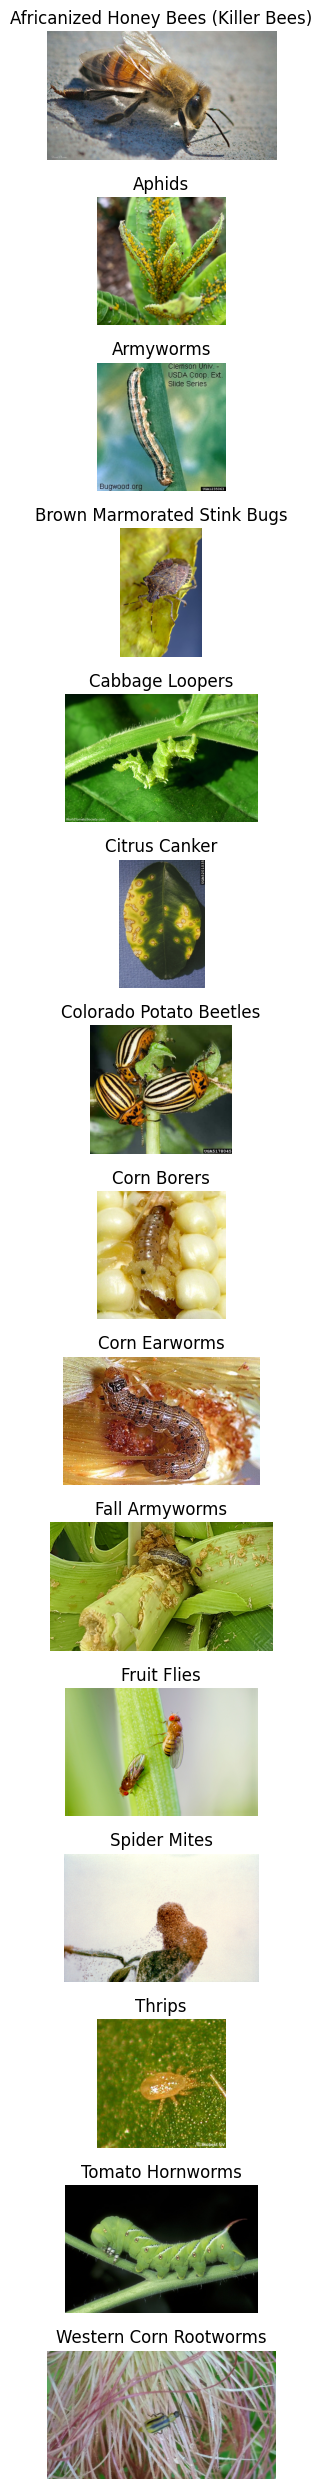

In [5]:
# Get list of classes (folder names)
classes = sorted(os.listdir(dataset_path))

# Display some images from each class side by side
plt.figure(figsize=(30, 25))  # Increase figure width here

num_samples_per_class = 1  # Number of samples to display per class

for i, cls in enumerate(classes):
    class_dir = os.path.join(dataset_path, cls)
    image_files = os.listdir(class_dir)[:num_samples_per_class]

    for j, image_file in enumerate(image_files):
        img_index = i * num_samples_per_class + j + 1
        img_path = os.path.join(class_dir, image_file)
        img = mpimg.imread(img_path)

        # Calculate subplot position
        plt.subplot(len(classes), num_samples_per_class, img_index)

        # Display image
        plt.imshow(img)
        plt.title(cls)  # Set title as class name
        plt.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()


In [6]:
def apply_histogram_equalization(dataset_path):
    # List all image files in the dataset directory
    image_files = os.listdir(dataset_path)

    # Iterate through each image file
    for image_file in tqdm(image_files):
        # Read image
        image_path = os.path.join(dataset_path, image_file)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)

        # Convert image to YUV color space (better for contrast enhancement)
        image_yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

        # Equalize the histogram of the Y channel (luminance)
        image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])

        # Convert back to RGB color space
        image_output = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2BGR)

        # Save the processed image back to the dataset directory (overwrite original)
        cv2.imwrite(image_path, image_output)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define preprocessing and augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally by 20% of width
    height_shift_range=0.2,     # Randomly shift images vertically by 20% of height
    shear_range=0.2,            # Shear intensity (shear angle in radians)
    zoom_range=0.2,             # Randomly zoom image by 20%
    horizontal_flip=True,       # Randomly flip images horizontally
    vertical_flip=True,         # Randomly flip images vertically
    fill_mode='nearest',         # Fill in missing pixels with the nearest value
    validation_split=0.2  # Splitting data into training (80%) and validation (20%)

)

# # Flow from directory with augmented data
# train_generator = train_datagen.flow_from_directory(dataset_path,
#     target_size=(224, 224),     # Resize images to (224, 224)
#     batch_size=32,              # Batch size
#     subset='validation',
#     class_mode='categorical'    # Classification mode for multi-class classification
# )

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),  # Resize images to 224x224 as required by ResNet
    batch_size=32,
    class_mode='categorical',
    subset='training',  # Specify this is training data
    shuffle=True
)

# Load and augment validation data
valid_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # Specify this is validation data
    shuffle=False
)


Found 1270 images belonging to 15 classes.
Found 309 images belonging to 15 classes.


In [8]:
# Load ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classifier layers on top of ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust number of epochs as needed
    validation_data=valid_generator,
    verbose=1
)


Epoch 1/10
40/40 [==============================] - 383s 10s/step - loss: 2.6091 - accuracy: 0.1331 - val_loss: 2.6115 - val_accuracy: 0.1456
Epoch 2/10
40/40 [==============================] - 375s 9s/step - loss: 2.6098 - accuracy: 0.1346 - val_loss: 2.6137 - val_accuracy: 0.1424
Epoch 3/10
40/40 [==============================] - 375s 9s/step - loss: 2.6032 - accuracy: 0.1315 - val_loss: 2.6072 - val_accuracy: 0.1262
Epoch 4/10
40/40 [==============================] - 366s 9s/step - loss: 2.5967 - accuracy: 0.1307 - val_loss: 2.6164 - val_accuracy: 0.1392
Epoch 5/10
40/40 [==============================] - 366s 9s/step - loss: 2.5920 - accuracy: 0.1394 - val_loss: 2.6274 - val_accuracy: 0.1392
Epoch 6/10
40/40 [==============================] - 383s 10s/step - loss: 2.6014 - accuracy: 0.1472 - val_loss: 2.6052 - val_accuracy: 0.1294
Epoch 7/10
40/40 [==============================] - 371s 9s/step - loss: 2.5958 - accuracy: 0.1472 - val_loss: 2.5986 - val_accuracy: 0.1586
Epoch 8/10


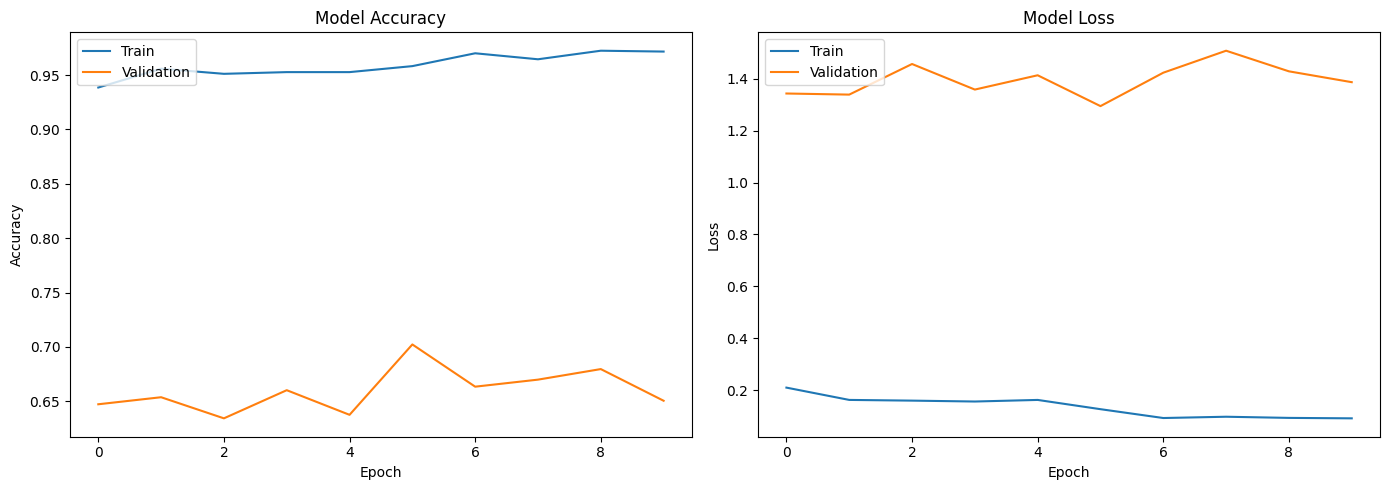

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
# Load ResNet101 model pre-trained on ImageNet data
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classifier layers on top of ResNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(train_generator.num_classes, activation='softmax')(x)  # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


171446536/171446536 [==============================] - 7s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                     

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,  # Adjust number of epochs as needed
    validation_data=valid_generator,
    verbose=1
)


Epoch 1/10
40/40 [==============================] - 545s 13s/step - loss: 2.0625 - accuracy: 0.3913 - val_loss: 1.3450 - val_accuracy: 0.5696
Epoch 2/10
40/40 [==============================] - 534s 13s/step - loss: 1.0407 - accuracy: 0.6835 - val_loss: 1.2200 - val_accuracy: 0.6375
Epoch 3/10
40/40 [==============================] - 531s 13s/step - loss: 0.6973 - accuracy: 0.7772 - val_loss: 1.2617 - val_accuracy: 0.6084
Epoch 4/10
40/40 [==============================] - 572s 14s/step - loss: 0.6257 - accuracy: 0.7795 - val_loss: 1.1905 - val_accuracy: 0.6472
Epoch 5/10
40/40 [==============================] - 531s 13s/step - loss: 0.4282 - accuracy: 0.8717 - val_loss: 1.2295 - val_accuracy: 0.6311
Epoch 6/10
40/40 [==============================] - 530s 13s/step - loss: 0.3397 - accuracy: 0.8787 - val_loss: 1.1290 - val_accuracy: 0.6861
Epoch 7/10
40/40 [==============================] - 531s 13s/step - loss: 0.2862 - accuracy: 0.9118 - val_loss: 1.2800 - val_accuracy: 0.6537
Epoch 

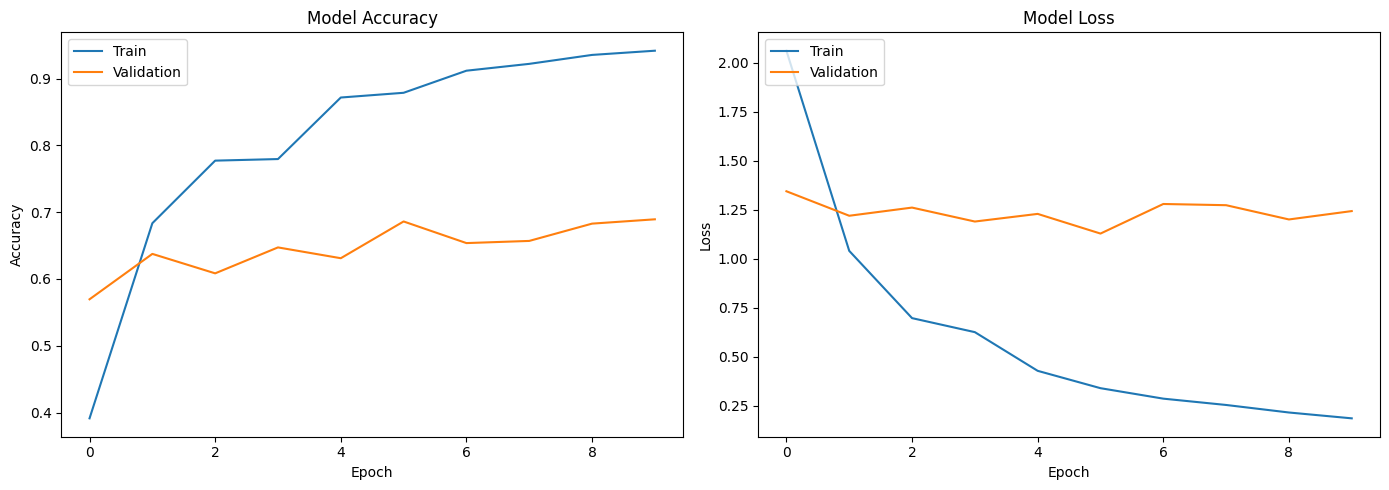

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
